In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
dataset_path = 'E:\\workspace\\학교_수업\\4학년자료\\22종프\\학습데이터\\dataset'

In [3]:
image_size = (180, 180)
batch_size = 16
epochs = 100
patience = 6
# patience: 학습 조기종료 인자. val_loss가 5epoch 동안 낮아지지 않으면 학습 종료

In [6]:
train_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

Found 3498 files belonging to 2 classes.
Using 2799 files for training.


In [7]:
valid_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

Found 3498 files belonging to 2 classes.
Using 699 files for validation.


In [8]:
labels = train_set.class_names
print(labels)
# ['non_smoking', 'smoking']

['non_smoking', 'smoking']


In [9]:
# 학습 성능 높이기
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_set = valid_set.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# 데이터 증강
data_augmentation = Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(
            'horizontal',
            input_shape=(180, 180, 3)
        ),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ]
)

In [11]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1000, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(400, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax'),
])

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [13]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=patience) # patience :: 참을성 인자, val_loss 값이 더이상 줄어들지 않으면 조기 종료
]

In [14]:
history = model.fit(
    train_set,
    validation_data=valid_set,
    callbacks=callbacks,
    epochs=epochs
)

Epoch 1/100
175/175 [==============================] - 10s 37ms/step - loss: 0.6598 - accuracy: 0.6284 - val_loss: 0.6488 - val_accuracy: 0.6152
Epoch 2/100
175/175 [==============================] - 6s 33ms/step - loss: 0.6094 - accuracy: 0.6577 - val_loss: 0.6093 - val_accuracy: 0.6338
Epoch 3/100
175/175 [==============================] - 6s 33ms/step - loss: 0.5502 - accuracy: 0.7188 - val_loss: 0.5194 - val_accuracy: 0.7253
Epoch 4/100
175/175 [==============================] - 6s 33ms/step - loss: 0.4976 - accuracy: 0.7588 - val_loss: 0.4341 - val_accuracy: 0.7597
Epoch 5/100
175/175 [==============================] - 6s 33ms/step - loss: 0.4571 - accuracy: 0.7946 - val_loss: 0.4407 - val_accuracy: 0.7911
Epoch 6/100
175/175 [==============================] - 6s 33ms/step - loss: 0.4100 - accuracy: 0.8185 - val_loss: 0.2991 - val_accuracy: 0.8712
Epoch 7/100
175/175 [==============================] - 6s 33ms/step - loss: 0.3767 - accuracy: 0.8321 - val_loss: 0.2640 - val_accuracy

In [15]:
# 검증 집합 평가
loss, accuracy = model.evaluate(valid_set)
print('Test Loss : ', loss)
print('Test Accuracy : ', accuracy)

44/44 [==============================] - 0s 10ms/step - loss: 0.1152 - accuracy: 0.9742
Test Loss :  0.11524423211812973
Test Accuracy :  0.9742489457130432


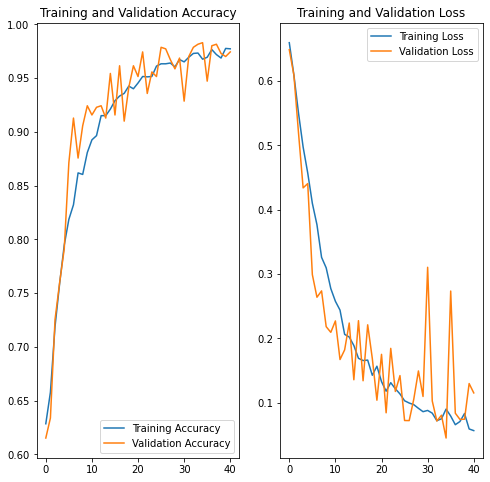

In [16]:
early_epoch = history.epoch[-1] + 1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

# 학습 종료시 epoch 기록
epochs_range = range(early_epoch)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.show()
plt.savefig('./new2_model0611_1_dataset_graph.png', facecolor='#FFFFFF')

In [17]:
model.save('./model/save_model_0611new2_1')
model.save('./model/save_model_0611new2_1.h5', save_format='h5')

INFO:tensorflow:Assets written to: ./model/save_model_0611new2_1\assets


INFO:tensorflow:Assets written to: ./model/save_model_0611new2_1\assets
